In [1]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
import joblib

X_train, X_test, y_train, y_test = joblib.load("artifacts/car_data_selected.joblib")

In [3]:
print(X_train.shape, X_test.shape)

(1324, 10) (331, 10)


# Base Model Evaluation

In [4]:
import joblib

# Load the price scaler
target_scaler = joblib.load('artifacts/price_yj_scaler.pkl')

def get_original_price(y_transformed):
    return target_scaler.inverse_transform(y_transformed.values.reshape(-1, 1)).flatten()

y_test_original = get_original_price(y_test)

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.base import RegressorMixin

def get_metrics(model: RegressorMixin):
    y_pred = model.predict(X_test)
    y_pred = get_original_price(pd.Series(y_pred))

    return {
        "MSE": mean_squared_error(y_test_original, y_pred),
        "RMSE": root_mean_squared_error(y_test_original, y_pred),
        "MAE": mean_absolute_error(y_test_original, y_pred),
        "R2": r2_score(y_test_original, y_pred)
    }

In [72]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

In [73]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Linear Regression...
Training Ridge...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training KNN...
Training SVR...
Training XGBoost...


In [74]:
# Compare all models

results = {name: get_metrics(model) for name, model in models.items()}
results_df = pd.DataFrame(results).T
results_df.sort_values(by="MSE")

,MSE,RMSE,MAE,R2
Gradient Boosting,9.490631e+10,308068.682047,172579.467432,0.919848
XGBoost,9.642720e+10,310527.299311,162659.774688,0.918564
Random Forest,1.160484e+11,340658.737368,182533.611543,0.901993
KNN,1.716373e+11,414291.274899,233232.899985,0.855046
Ridge,1.911836e+11,437245.478825,246805.228158,0.838538
Linear Regression,1.912005e+11,437264.761115,247364.144406,0.838524
Decision Tree,1.912949e+11,437372.691126,221375.401729,0.838444
SVR,3.995155e+11,632072.358850,211810.106233,0.662594


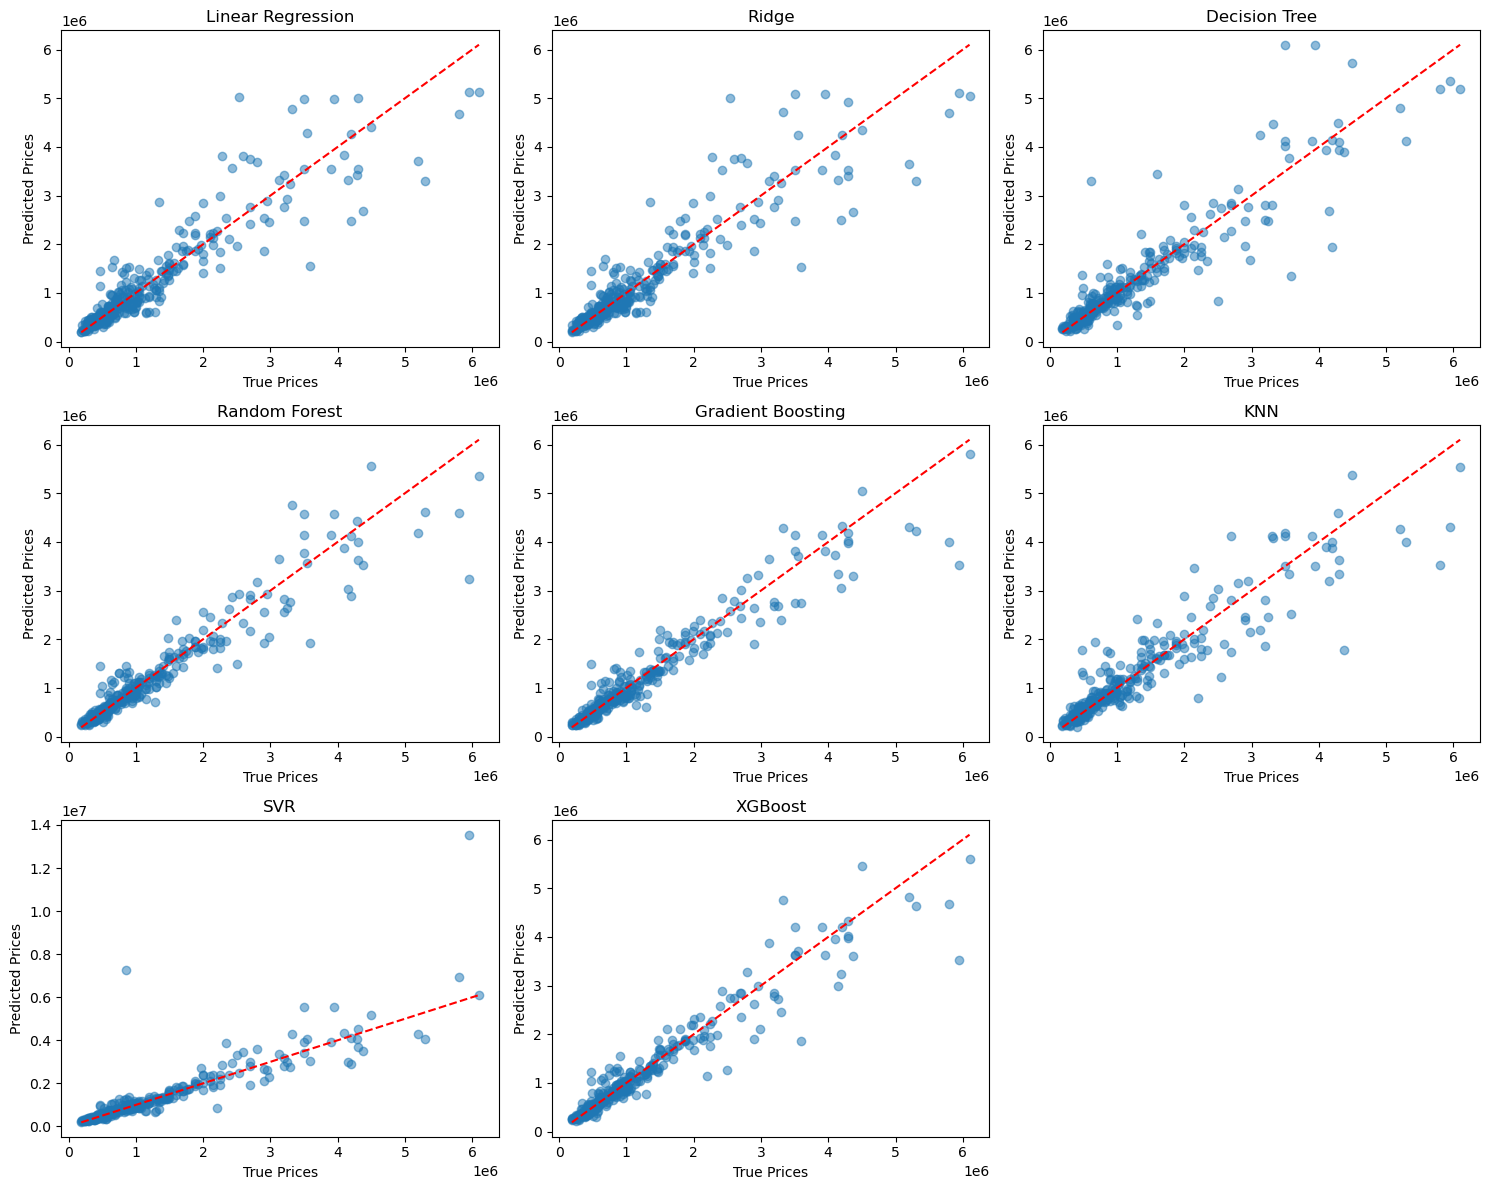

In [ ]:
# Plot subplots for models
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(3, 3, i)
    y_pred = model.predict(X_test)
    y_pred = get_original_price(pd.Series(y_pred))
    plt.scatter(y_test_original, y_pred, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 'r--')
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.title(name)
    plt.tight_layout()
plt.show()

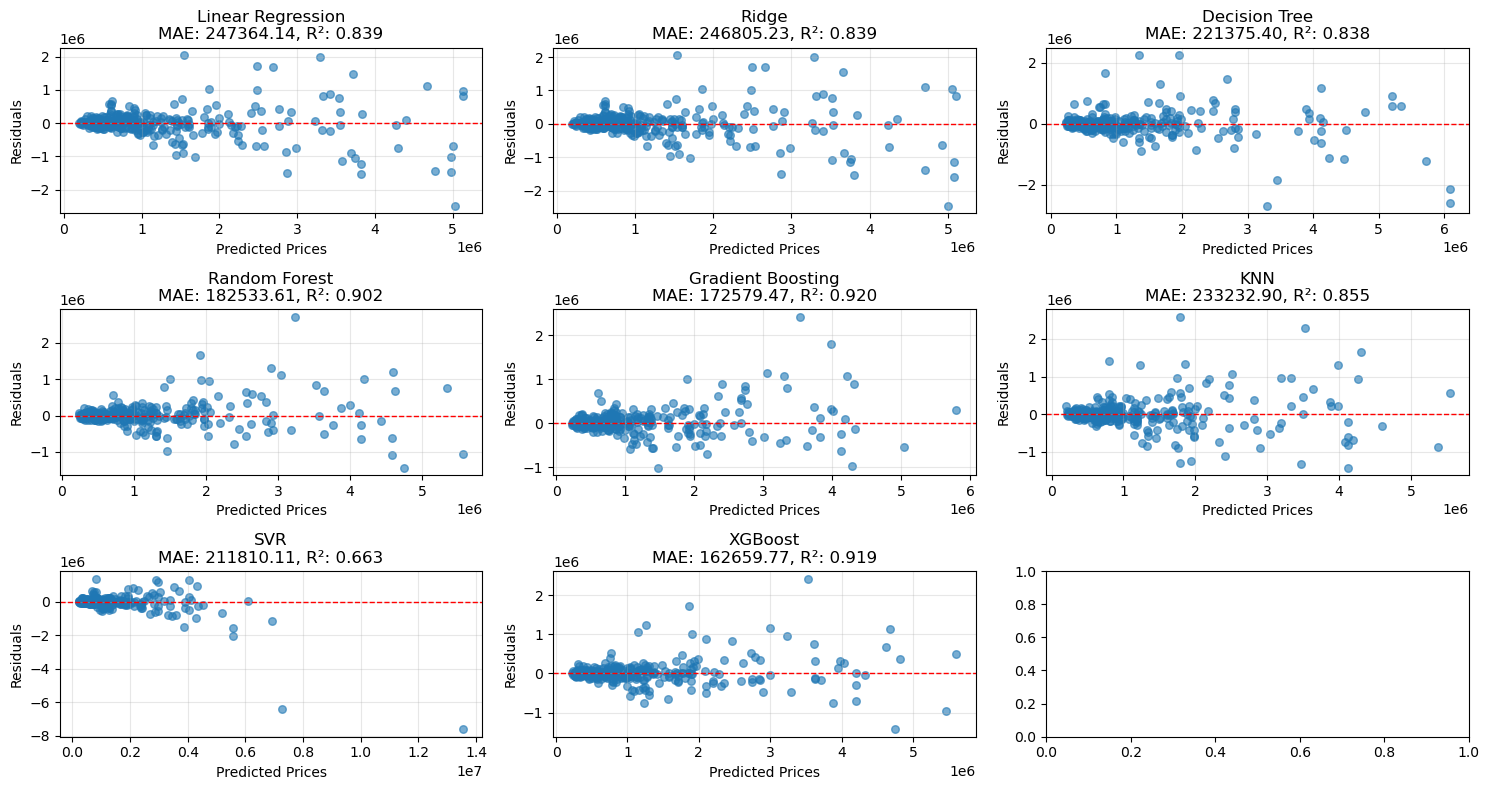

In [104]:
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
axes = axes.flatten()  # Flatten to 1D for easier iteration

for i, (name, model) in enumerate(models.items()):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_original = get_original_price(pd.Series(y_pred))
    
    # Calculate residuals
    residuals = y_test_original - y_pred_original
    
    # Create residual plot
    axes[i].scatter(y_pred_original, residuals, alpha=0.6, s=30)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    
    # Add metrics to title
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    axes[i].set_title(f"{name}\nMAE: {mae:.2f}, R²: {r2:.3f}")
    axes[i].set_xlabel("Predicted Prices")
    axes[i].set_ylabel("Residuals")
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

## Random Forest

In [75]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    n_jobs=-1,
    n_iter=30,
    random_state=42
)

rand_rf.fit(X_train, y_train)
best_rf = rand_rf.best_estimator_
print("Best RF Params:", rand_rf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [77]:
get_metrics(rand_rf)

{'MSE': 114578847094.9871,
 'RMSE': 338494.97351509833,
 'MAE': 176089.44633768327,
 'R2': 0.9032338078480973}

## Gradient Boosting

In [79]:
# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": np.arange(100, 1000, 100),   # number of boosting stages
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],  # shrinkage
    "max_depth": [3, 5, 7, 10],                  # depth of individual trees
    "min_samples_split": [2, 5, 10],             # min samples to split a node
    "min_samples_leaf": [1, 2, 4],               # min samples in a leaf
    "max_features": ["auto", "sqrt", "log2", None],  # feature sampling
    "subsample": [0.6, 0.8, 1.0]                 # stochastic gradient boosting
}

# Randomized search
rand_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=30,   # number of random combinations
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rand_gb.fit(X_train, y_train)

# Best estimator and params
best_gb = rand_gb.best_estimator_
print("Best GB Params:", rand_gb.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best GB Params: {'subsample': 0.6, 'n_estimators': 900, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.01}


In [80]:
get_metrics(rand_gb)

{'MSE': 81938613407.8456,
 'RMSE': 286249.21555848076,
 'MAE': 156747.12588078485,
 'R2': 0.930799726033978}

## XGBoost

In [81]:
# Perform randomized search for XGBoost
xgb = XGBRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": np.arange(100, 1000, 100),
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_xgb.fit(X_train, y_train)
best_xgb = rand_xgb.best_estimator_
print("Best XGB Params:", rand_xgb.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [82]:
get_metrics(rand_xgb)

{'MSE': 66416323866.38869,
 'RMSE': 257713.64703171753,
 'MAE': 151476.24442975858,
 'R2': 0.9439088896404234}

## Final Model Evaluation

In [84]:
# Collect all models and their metrics
best_models = {
    "Random Forest (Initial)": models["Random Forest"],
    "Random Forest (Randomized Search)": rand_rf.best_estimator_,
    "Gradient Boosting (Initial)": models["Gradient Boosting"],
    "Gradient Boosting (Randomized Search)": rand_gb.best_estimator_,
    "XGBoost (Initial)": models["XGBoost"],
    "XGBoost (Randomized Search)": rand_xgb.best_estimator_,
}

In [87]:
# Get metrics for best models
results_df = pd.DataFrame({
    model_name: get_metrics(model) for model_name, model in best_models.items()
}).T
results_df.sort_values(by="MSE")

,MSE,RMSE,MAE,R2
XGBoost (Randomized Search),6.641632e+10,257713.647032,151476.244430,0.943909
Gradient Boosting (Randomized Search),8.193861e+10,286249.215558,156747.125881,0.930800
Gradient Boosting (Initial),9.490631e+10,308068.682047,172579.467432,0.919848
XGBoost (Initial),9.642720e+10,310527.299311,162659.774688,0.918564
Random Forest (Randomized Search),1.145788e+11,338494.973515,176089.446338,0.903234
Random Forest (Initial),1.160484e+11,340658.737368,182533.611543,0.901993


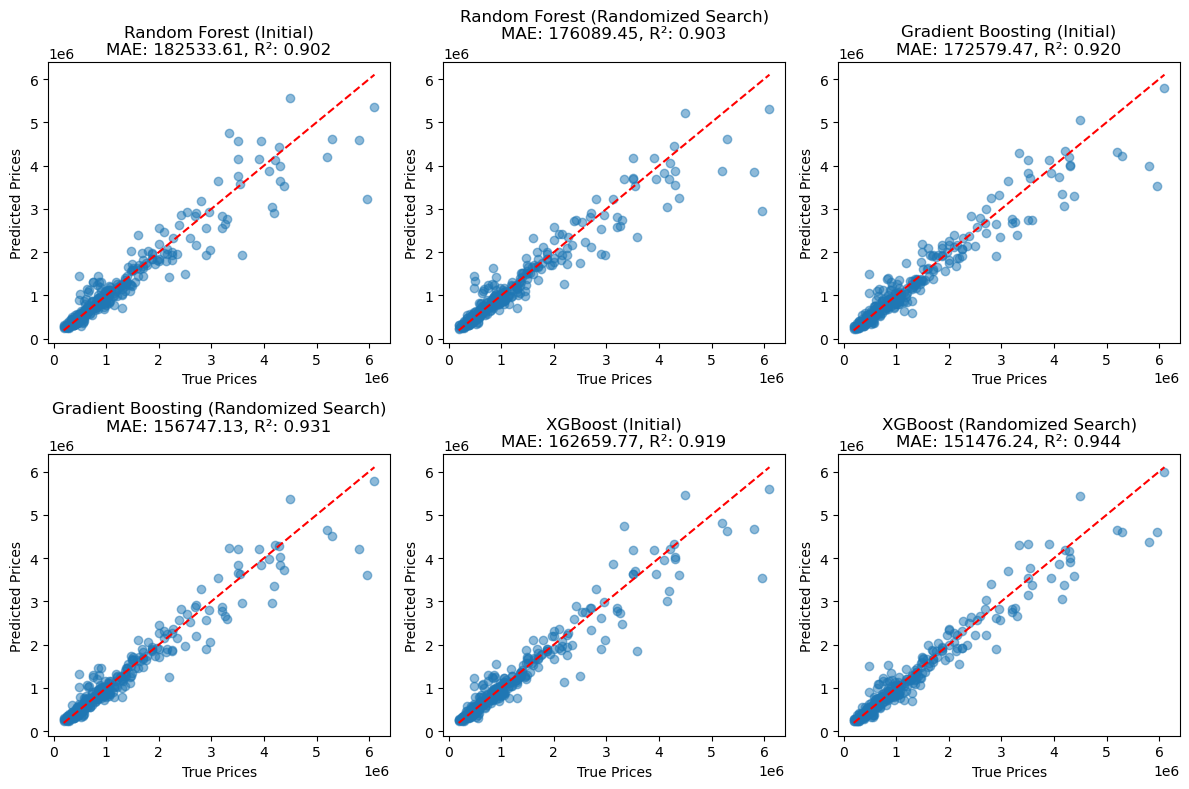

In [102]:
plt.figure(figsize=(12, 8))

for i, (name, model) in enumerate(best_models.items(), 1):
    plt.subplot(2, 3, i)
    y_pred = model.predict(X_test)
    y_pred_original = get_original_price(pd.Series(y_pred))
    
    # Add metrics to title
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 'r--')
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"{name}\nMAE: {mae:.2f}, R²: {r2:.3f}")
    plt.tight_layout()
plt.show()

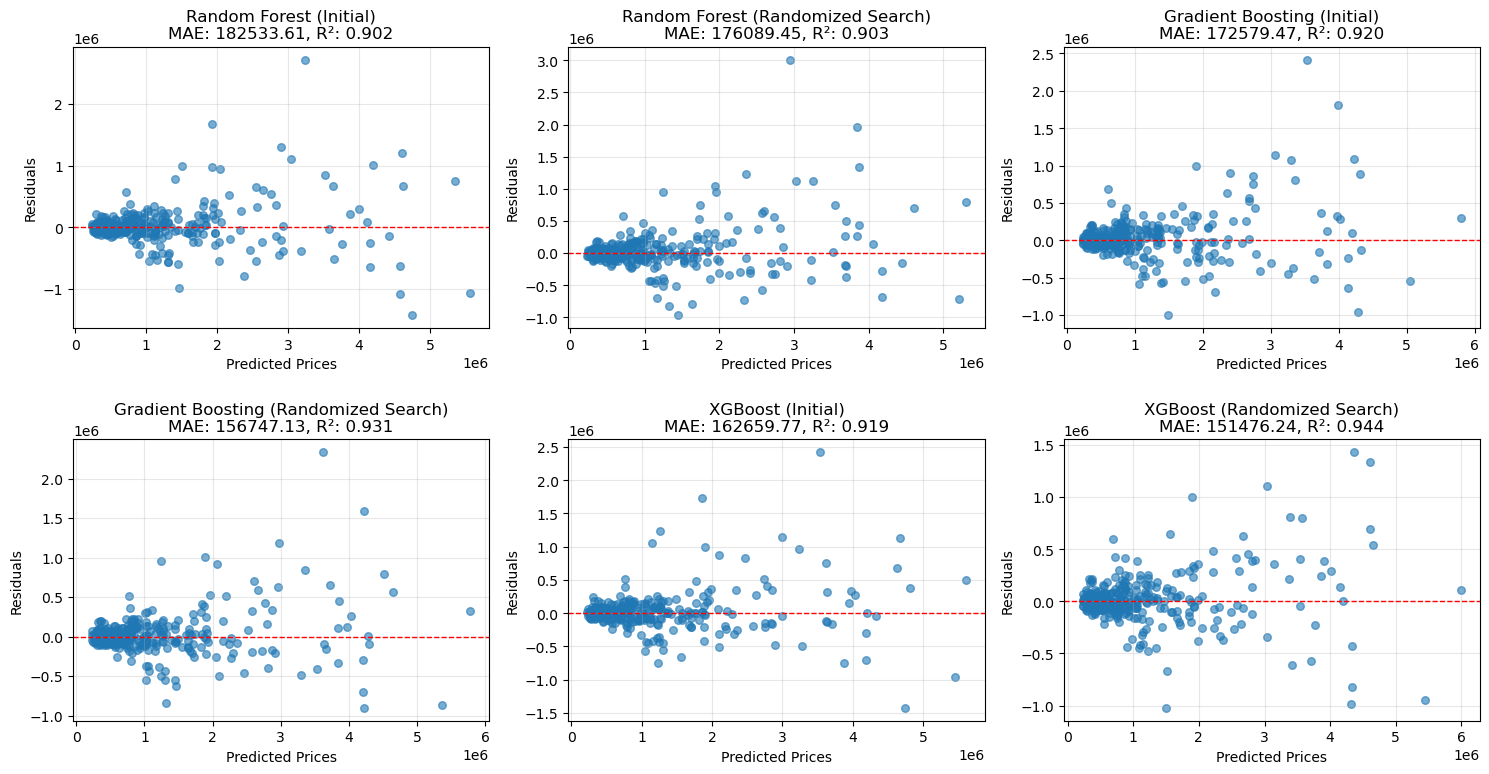

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  # Flatten to 1D for easier iteration

for i, (name, model) in enumerate(best_models.items()):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_original = get_original_price(pd.Series(y_pred))
    
    # Calculate residuals
    residuals = y_test_original - y_pred_original
    
    # Create residual plot
    axes[i].scatter(y_pred_original, residuals, alpha=0.6, s=30)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    
    # Add metrics to title
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    axes[i].set_title(f"{name}\nMAE: {mae:.2f}, R²: {r2:.3f}")
    axes[i].set_xlabel("Predicted Prices")
    axes[i].set_ylabel("Residuals")
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()